In [1]:
# standard packages used to handle files
import sys
import os 
import glob
import time

from tqdm import tqdm

# commonly used library for data manipulation
import pandas as pd

# numerical
import numpy as np

# handle images - opencv
import cv2

# machine learning library
import sklearn
import sklearn.preprocessing

# used to serialize python objects to disk and load them back to memory
import pickle

# plotting
import matplotlib.pyplot as plt

# helper functions
import helpers

# specific helper functions for feature extraction
import features

from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.ensemble import BaggingClassifier



from sklearn.metrics import log_loss

from sklearn.metrics import confusion_matrix
import pylab as pl

from sklearn.model_selection import learning_curve

# tell matplotlib that we plot in a notebook
%matplotlib notebook

%matplotlib inline

In [2]:
# Normalize the images



dataset_path = "./images/"


dataset_path_train = os.path.join(dataset_path, 'train')
dataset_path_test = os.path.join(dataset_path, 'test')

def getImgPaths(data_folder):
    """Returns filepaths of all files contained in the given folder as strings."""
    return np.sort(glob.glob(os.path.join(data_folder, '*')))

folder_paths = glob.glob(os.path.join(dataset_path_train,'*'))
label_strings = np.sort(np.array([os.path.basename(path) for path in folder_paths]))

train_paths = dict((label_string, getImgPaths(os.path.join(dataset_path_train, label_string)))
                   for label_string in label_strings)

for image_paths in train_paths.values():
    for image_path in tqdm(image_paths):
        image = cv2.imread(image_path)
        norm_img = np.zeros((800,800))
        image = cv2.normalize(image,  norm_img, 0, 255, cv2.NORM_MINMAX)    
        new_path = image_path.replace(image_path[:image_path.index("images")],"normalized_" )
        cv2.imwrite(new_path, image)
        
        

100%|██████████| 383/383 [00:50<00:00,  7.55it/s]


In [3]:
test_paths = getImgPaths(dataset_path_test)

for image_path in tqdm(test_paths):
    image = cv2.imread(image_path)
    norm_img = np.zeros((800,800))
    image = cv2.normalize(image,  norm_img, 0, 255, cv2.NORM_MINMAX)    
    new_path = image_path.replace(image_path[:image_path.index("images")],"normalized_" )
    cv2.imwrite(new_path, image)
            

100%|██████████| 4035/4035 [05:24<00:00, 12.42it/s]


In [4]:
# filepath constants, set these according to your workflow:

# where are your datasets:
dataset_path = './normalized_images/'
# where do you want to save your features and other outputs:
output_path = './normalized_output/'

In [5]:
# you don't have to change the paths here:

dataset_path_train = os.path.join(dataset_path, 'train')
dataset_path_test = os.path.join(dataset_path, 'test')

features_path = os.path.join(output_path, 'features')
features_path_train = os.path.join(features_path, 'train')
features_path_test = os.path.join(features_path, 'test')

prediction_path = os.path.join(output_path, 'predictions')

# filepatterns to write out features
filepattern_descriptor_train = os.path.join(features_path_train, 'train_features_{}.pkl')
filepattern_descriptor_test = os.path.join(features_path_test, 'test_features_{}.pkl')

# create paths in case they don't exist:
helpers.createPath(features_path)
helpers.createPath(features_path_train)
helpers.createPath(features_path_test)
helpers.createPath(prediction_path)

In [6]:
folder_paths = glob.glob(os.path.join(dataset_path_train,'*'))
label_strings = np.sort(np.array([os.path.basename(path) for path in folder_paths]))
num_classes = label_strings.shape[0]

print("Amount of classes: ", num_classes)
print("\nLabels: \n", label_strings)

Amount of classes:  12

Labels: 
 ['chicken' 'elephant' 'fox' 'german_shepherd' 'golden_retriever' 'horse'
 'jaguar' 'lion' 'owl' 'parrot' 'swan' 'tiger']


In [7]:
train_paths = dict((label_string, helpers.getImgPaths(os.path.join(dataset_path_train, label_string))) 
                   for label_string in label_strings)

In [8]:
# Add all features which you would like to see computed and their callbacks to this dictionary
# Features where a pickle file already exists will not be recomputed

descriptor_dict = {
    'daisy': features.extractDAISYCallback, # SIFT replacement, very fast, can be computed dense if necessary
}

In [9]:
train_descriptor_dict = descriptor_dict.copy()

# if the corresponding files already exist, do not extract them again
train_descriptor_dict = dict(
    (key, value) for (key, value) in descriptor_dict.items() 
    if not os.path.isfile(filepattern_descriptor_train.format(key))
)

if len(train_descriptor_dict) > 0:
    train_features = []
    train_labels = []
    
    # convert train images
    train_features_by_descriptor = dict((key, []) for (key,value) in train_descriptor_dict.items())
    
    for label_string in label_strings:
        print('Extracting train features for class {} :'.format(label_string))

        extracted_features = features.extractFeatures(train_paths[label_string], train_descriptor_dict, label_string)

        # append descriptors of corresponding label to correct descriptor list 
        for key in train_features_by_descriptor.keys():
            train_features_by_descriptor[key] += extracted_features[key]
  
    for descriptor_key in train_features_by_descriptor.keys():
        with open(filepattern_descriptor_train.format(descriptor_key), 'wb') as pkl_file_train:
            pickle.dump(train_features_by_descriptor[descriptor_key], pkl_file_train, protocol=pickle.HIGHEST_PROTOCOL)

Extracting train features for class chicken :


100%|██████████| 550/550 [00:22<00:00, 24.12it/s]

Extracting train features for class elephant :



100%|██████████| 435/435 [00:24<00:00, 18.04it/s]


Extracting train features for class fox :


100%|██████████| 249/249 [02:34<00:00,  1.61it/s]

Extracting train features for class german_shepherd :



100%|██████████| 462/462 [03:31<00:00,  2.18it/s]

Extracting train features for class golden_retriever :



100%|██████████| 75/75 [00:12<00:00,  5.96it/s]

Extracting train features for class horse :



100%|██████████| 466/466 [00:20<00:00, 22.34it/s]

Extracting train features for class jaguar :



100%|██████████| 87/87 [00:37<00:00,  2.31it/s]

Extracting train features for class lion :



100%|██████████| 394/394 [03:41<00:00,  1.78it/s]

Extracting train features for class owl :



100%|██████████| 321/321 [02:50<00:00,  1.88it/s]

Extracting train features for class parrot :



100%|██████████| 406/406 [04:06<00:00,  1.65it/s]

Extracting train features for class swan :



100%|██████████| 214/214 [02:02<00:00,  1.75it/s]

Extracting train features for class tiger :



100%|██████████| 383/383 [02:58<00:00,  2.15it/s]


In [10]:
test_descriptor_dict = dict(
    (key,value) for (key,value) in descriptor_dict.items() 
    if not os.path.isfile(filepattern_descriptor_test.format(key))
)

if len(test_descriptor_dict) > 0: 
    test_features = []
    
    print('Extracting test features:') 
    
    test_features_by_descriptor = features.extractFeatures(test_paths, test_descriptor_dict, None) 
    
    for descriptor_key in test_features_by_descriptor.keys():
        with open(filepattern_descriptor_test.format(descriptor_key), 'wb') as pkl_file_test:
            pickle.dump(test_features_by_descriptor[descriptor_key], pkl_file_test, protocol=pickle.HIGHEST_PROTOCOL)

Extracting test features:


100%|██████████| 4035/4035 [24:25<00:00,  2.75it/s]  


In [11]:
def evaluate_models(X_train, X_valid, ytrain, yvalid, descriptor_desired):
    

    print('\n')
    
    #### SVM ####
    
    print(f" SVM ".center(40,'*'))

    # define support vector classifier
    model = SVC(kernel='linear',probability=True, random_state=42)

    # fit model
    model.fit(X_train, ytrain)
    
    display_metrics(X_train, X_valid, ytrain, yvalid, descriptor_desired, model,"SVM with normalized")
        
    #### SVM Bagging ####
    
    print(f" SVM with bagging ".center(40,'*'))

    # define support vector classifier
    model = SVC(kernel='linear',probability=True, random_state=42)
    model = BaggingClassifier(base_estimator=model, n_estimators=10, random_state=42)

    # fit model
    model.fit(X_train, ytrain)
    
    display_metrics(X_train, X_valid, ytrain, yvalid, descriptor_desired, model,"SVM Bagging with normalized")

In [12]:
def display_metrics(X_train, X_valid, ytrain, yvalid, descriptor_desired, model, model_name):
    print(f'\nclassification accuracy for {model_name} ({descriptor_desired}): ' +repr(model.score(X_valid,yvalid)))
    print(f'training accuracy for {model_name} ({descriptor_desired}): ' +repr(model.score(X_train,ytrain))+"\n")


    #get confusion matrix
    predictions_abs = model.predict(X_valid)
    cm = confusion_matrix(yvalid, predictions_abs)

    #display matrix
    print(cm)


    # plot confusion matrix
    pl.matshow(cm)
    pl.title(f'Confusion matrix for {model_name} ({descriptor_desired})')
    pl.colorbar()
    pl.ylabel('True class label')
    pl.xlabel('Predicted class label')
    pl.show()   

    predictions_proba = model.predict_proba(X_valid)
    ll = log_loss(yvalid, predictions_proba)
    print('\n\nAverage Log Loss for ',model_name,' (', descriptor_desired, '): %.3f' %ll)

    print('\n')
    
    

In [13]:
descriptors = ['daisy']

###################################  daisy  ####################################
Number of encoded train images: 4042
training took 659.1975190639496 seconds

Number of images for training : 3233
Number of images for validation : 809


***************** SVM ******************

classification accuracy for SVM with normalized (daisy): 0.5179233621755254
training accuracy for SVM with normalized (daisy): 0.7992576554283947

[[82 12  2 12  0 18  0  0  3  2  0  0]
 [17 40  1  4  0 12  0  1  1  0  1  0]
 [ 1  3 11  7  0  0  0 14  4  8  1  6]
 [12  6  3 33  0 11  0 10  5 10  2  3]
 [ 5  0  1  9  0  1  0  0  1  4  1  0]
 [15 18  0  3  0 54  0  0  0  0  0  0]
 [ 1  0  0  1  0  0  3  1  1  0  0  5]
 [ 1  1  3 10  0  0  0 57  4  2  1  6]
 [ 2  0  1  3  0  0  2  4 21 15  1  3]
 [ 1  0  6  3  0  0  0  5 12 43  2  1]
 [ 1  0  1  1  0  0  0  0  2 10 27  1]
 [ 1  0  2  4  0  3  0  9  4  3  0 48]]


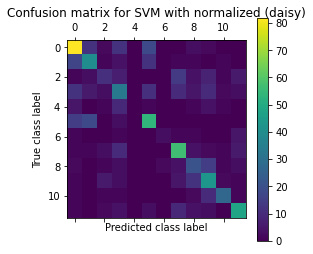



Average Log Loss for  SVM with normalized  ( daisy ): 1.394


*********** SVM with bagging ***********

classification accuracy for SVM Bagging with normalized (daisy): 0.5265760197775031
training accuracy for SVM Bagging with normalized (daisy): 0.851221775440767

[[77 15  1 14  0 19  0  0  2  3  0  0]
 [14 41  3  4  0 12  0  1  1  0  1  0]
 [ 0  4 11  8  0  0  0 10  6  7  1  8]
 [11  7  2 36  0 11  0  8  4  9  3  4]
 [ 2  0  0 10  0  1  0  1  2  4  2  0]
 [13 20  0  2  0 55  0  0  0  0  0  0]
 [ 0  0  0  1  0  1  5  1  1  0  0  3]
 [ 1  1  4  5  0  0  1 56  5  2  1  9]
 [ 1  0  0  3  0  1  2  4 20 14  1  6]
 [ 1  0  4  3  0  0  0  4 11 46  2  2]
 [ 1  0  1  1  0  0  0  0  1 10 28  1]
 [ 0  0  3  6  0  3  0  4  4  3  0 51]]


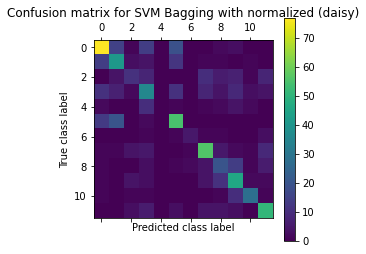

In [ ]:
for descriptor_desired in descriptors:
    
    print(f'  {descriptor_desired}  '.center(80,'#'))
    
    with open(filepattern_descriptor_train.format(descriptor_desired), 'rb') as pkl_file_train:
        train_features_from_pkl = pickle.load(pkl_file_train)
    
    print('Number of encoded train images: {}'.format(len(train_features_from_pkl)))
        
    codebook_size = 1700

    clustered_codebook = helpers.createCodebook(train_features_from_pkl, codebook_size=codebook_size)
    
    # encode all train images 
    train_data = []
    train_labels = []

    for image_features in train_features_from_pkl:
        bow_feature_vector = helpers.encodeImage(image_features.data, clustered_codebook)
        train_data.append(bow_feature_vector)
        train_labels.append(image_features.label)
        

    # use a labelencoder to obtain numerical labels
    label_encoder = sklearn.preprocessing.LabelEncoder()
    label_encoder.fit(label_strings)
    train_labels = label_encoder.transform(train_labels)
    
    #Split Train Data for training and validations.
    X_train, X_valid, ytrain, yvalid = train_test_split(train_data, train_labels, test_size=0.2,random_state=42)
    print("\nNumber of images for training :",len(X_train))
    print("Number of images for validation :", len(X_valid))
    
    evaluate_models(X_train, X_valid, ytrain, yvalid, descriptor_desired)